In [ ]:
import pandas as pd
import numpy as np
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae, rmse, mape  # noqa
from darts.models import (
    LinearRegressionModel,
    NaiveSeasonal,
    ExponentialSmoothing 

)
from darts.utils.model_selection import train_test_split
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.dataprocessing.transformers import MissingValuesFiller
# from darts.utils.likelihood_models import GaussianLikelihood
import matplotlib.pyplot as plt
from tasks_support_system_ai.utils.utils import get_correct_data_path
from tasks_support_system_ai.data.parse_data import read_proper_ts_tree, ts_read_daily_tickets
from tasks_support_system_ai.data.inference_preprocesser import create_preprocessing_pipeline, create_transformed_df
import seaborn as sns
import random
import matplotlib.cm as cm
from sklearn.ensemble import IsolationForest
import warnings
from darts.models import NBEATSModel, TransformerModel, TiDEModel, RNNModel
from pytorch_lightning.callbacks import EarlyStopping
import torch
from tqdm import tqdm
from pytorch_lightning.loggers import CSVLogger

Загружаем данные

In [4]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))
tree = read_proper_ts_tree(get_correct_data_path("custom_data/tree_proper.csv"))

In [5]:
top_level_tree = tree[(tree["level"] == 1) & (tree["full_load"] != 0)]
top_level_tree.sort_values("full_load", ascending=False)

,queueId,level,immediateDescendants,allDescendants,full_load
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146
481,1866,1,"[4307, 4352, 4587, 4667, 4682, 762, 100081, 10...","[762, 1866, 2382, 2733, 3536, 3576, 3617, 3836...",1470013
285,742,1,"[39, 98, 118, 4322, 4412, 2458, 2610, 2921, 3093]","[9, 13, 26, 39, 83, 98, 101, 110, 116, 118, 37...",1387729
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019
163,4447,1,"[57, 4457, 4612, 4617, 100254, 100261, 4793, 1...","[57, 382, 1162, 1741, 1881, 1887, 1981, 2007, ...",1121534
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237
41,4147,1,"[7, 14, 4442, 100329, 100034, 100092, 100105, ...","[7, 14, 2544, 3045, 3086, 3095, 3551, 3884, 41...",681754


In [6]:
def get_df_slice(queue_id: int):
    queues = tree[tree["queueId"] == queue_id]["allDescendants"].values[0]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice

In [7]:
top_level_queue_ids = top_level_tree['queueId'].tolist()

In [ ]:
global_df_top_level = pd.DataFrame()

for queue_id in top_level_queue_ids:
    df_queue = get_df_slice(queue_id)
    df_queue['queue_id'] = queue_id 
    global_df_top_level = pd.concat([global_df_top_level, df_queue])

global_df_top_level = global_df_top_level.reset_index()

global_df_top_level

,date,new_tickets,queue_id
0,2017-01-01,195,10
1,2017-01-02,274,10
2,2017-01-03,300,10
3,2017-01-04,283,10
4,2017-01-05,311,10
...,...,...,...
27819,2020-09-26,299,3936
27820,2020-09-27,330,3936
27821,2020-09-28,494,3936
27822,2020-09-29,554,3936


In [9]:
global_df_top_level = global_df_top_level.dropna()

In [10]:
lags_to_create = [1, 2, 3, 7, 14, 21, 28, 30]
lags_for_rolling = [1, 7, 14]
windows_for_rolling = [3, 7, 14]

Сделаем предобработку данных. Добавим признаки

In [11]:
global_df_transformed = create_transformed_df(
    df= global_df_top_level,
    lags_to_create= lags_to_create,
    lags_for_rolling= lags_for_rolling,
    windows_for_rolling= windows_for_rolling
)

global_df_transformed.head()

,date,new_tickets,queue_id,dayofweek,month,year,new_tickets_lag_1,new_tickets_lag_2,new_tickets_lag_3,new_tickets_lag_7,...,new_tickets_lag_7_rolling_std_14,new_tickets_lag_14_rolling_mean_3,new_tickets_lag_14_rolling_median_3,new_tickets_lag_14_rolling_std_3,new_tickets_lag_14_rolling_mean_7,new_tickets_lag_14_rolling_median_7,new_tickets_lag_14_rolling_std_7,new_tickets_lag_14_rolling_mean_14,new_tickets_lag_14_rolling_median_14,new_tickets_lag_14_rolling_std_14
31,2017-02-01,648,10,2,2,2017,705.0,694.0,305.0,608.0,...,148.492424,718.500000,718.5,112.429978,718.500000,718.5,112.429978,718.500000,718.5,112.429978
32,2017-02-02,600,10,3,2,2017,648.0,705.0,694.0,689.0,...,105.910339,708.666667,689.0,81.303956,708.666667,689.0,81.303956,708.666667,689.0,81.303956
33,2017-02-03,640,10,4,2,2017,600.0,648.0,705.0,603.0,...,100.394223,650.666667,639.0,34.034296,687.500000,664.0,78.733728,687.500000,664.0,78.733728
34,2017-02-04,327,10,5,2,2017,640.0,600.0,648.0,318.0,...,183.563885,558.333333,624.0,173.107866,622.400000,639.0,160.746073,622.400000,639.0,160.746073
35,2017-02-05,280,10,6,2,2017,327.0,640.0,600.0,305.0,...,205.371290,428.666667,362.0,171.980619,568.666667,631.5,194.923233,568.666667,631.5,194.923233


In [12]:
all_series = []
all_past_covariates = []
all_future_covariates = []

all_feature_cols = [col for col in global_df_transformed.columns if col not in ['date', 'queue_id', 'new_tickets']]

future_covariate_cols = ['dayofweek', 'month', 'year']

past_covariate_cols = [col for col in all_feature_cols if col not in future_covariate_cols]

print(f"\nОпределены Future Covariates: {future_covariate_cols}")
print(f"Определены Past Covariates: {past_covariate_cols}")


for queue_id in global_df_transformed['queue_id'].unique():
    df_queue = global_df_transformed[global_df_transformed['queue_id'] == queue_id].copy()
    
    target_series = TimeSeries.from_dataframe(df_queue, time_col='date', value_cols='new_tickets', freq="D")
    all_series.append(target_series)
    
    if future_covariate_cols:
        future_cov_series = TimeSeries.from_dataframe(df_queue, time_col='date', value_cols=future_covariate_cols, freq="D")
        all_future_covariates.append(future_cov_series)
    else:
        all_future_covariates.append(None) 

    if past_covariate_cols:
        past_cov_series = TimeSeries.from_dataframe(df_queue, time_col='date', value_cols=past_covariate_cols, freq="D")
        all_past_covariates.append(past_cov_series)
    else:
        all_past_covariates.append(None)




Определены Future Covariates: ['dayofweek', 'month', 'year']
Определены Past Covariates: ['new_tickets_lag_1', 'new_tickets_lag_2', 'new_tickets_lag_3', 'new_tickets_lag_7', 'new_tickets_lag_14', 'new_tickets_lag_21', 'new_tickets_lag_28', 'new_tickets_lag_30', 'is_anomaly', 'new_tickets_lag_1_rolling_mean_3', 'new_tickets_lag_1_rolling_median_3', 'new_tickets_lag_1_rolling_std_3', 'new_tickets_lag_1_rolling_mean_7', 'new_tickets_lag_1_rolling_median_7', 'new_tickets_lag_1_rolling_std_7', 'new_tickets_lag_1_rolling_mean_14', 'new_tickets_lag_1_rolling_median_14', 'new_tickets_lag_1_rolling_std_14', 'new_tickets_lag_7_rolling_mean_3', 'new_tickets_lag_7_rolling_median_3', 'new_tickets_lag_7_rolling_std_3', 'new_tickets_lag_7_rolling_mean_7', 'new_tickets_lag_7_rolling_median_7', 'new_tickets_lag_7_rolling_std_7', 'new_tickets_lag_7_rolling_mean_14', 'new_tickets_lag_7_rolling_median_14', 'new_tickets_lag_7_rolling_std_14', 'new_tickets_lag_14_rolling_mean_3', 'new_tickets_lag_14_rollin

Разобьем данные на train/val/test

In [13]:
test_size = 0.2

train_series, test_series = train_test_split(all_series, test_size=test_size)
train_past_cov, test_past_cov = train_test_split(all_past_covariates, test_size=test_size)
train_future_cov, test_future_cov = train_test_split(all_future_covariates, test_size=test_size)

val_size = 0.15
train_series_final, val_series = train_test_split(train_series, test_size=val_size)
train_past_cov_final, val_past_cov = train_test_split(train_past_cov, test_size=val_size)
train_future_cov_final, val_future_cov = train_test_split(train_future_cov, test_size=val_size)

Заполним пропуски

In [14]:
filler = MissingValuesFiller(fill='auto')

if train_series_final: 
    train_series_filled = filler.transform(train_series_final)
    val_series_filled = filler.transform(val_series)
    test_series_filled = filler.transform(test_series)
    print("NaN в целевых рядах импутированы.")
else:
    train_series_filled = train_series_final
    val_series_filled = val_series
    test_series_filled = test_series
    print("Список целевых рядов пуст, импутация пропущена.")


if train_past_cov_final and all(cov is not None for cov in train_past_cov_final):
    train_past_cov_filled = filler.transform(train_past_cov_final)
    val_past_cov_filled = filler.transform(val_past_cov)
    test_past_cov_filled = filler.transform(test_past_cov)
    print("NaN в Past covariates импутированы.")
else:
    train_past_cov_filled = train_past_cov_final
    val_past_cov_filled = val_past_cov
    test_past_cov_filled = test_past_cov
    print("Список Past covariates пуст или содержит None, импутация пропущена.")

if train_future_cov_final and all(cov is not None for cov in train_future_cov_final):
    train_future_cov_filled = filler.transform(train_future_cov_final)
    val_future_cov_filled = filler.transform(val_future_cov)
    test_future_cov_filled = filler.transform(test_future_cov)
    print("NaN в Future covariates импутированы.")
else:
    train_future_cov_filled = train_future_cov_final
    val_future_cov_filled = val_future_cov
    test_future_cov_filled = test_future_cov
    print("Список Future covariates пуст или содержит None, импутация пропущена.")

NaN в целевых рядах импутированы.
NaN в Past covariates импутированы.
NaN в Future covariates импутированы.


Масштабируем данные

In [ ]:
scaler_target = Scaler()
scaler_past_cov = Scaler()
scaler_future_cov = Scaler()

train_series_scaled = scaler_target.fit_transform(train_series_filled)
val_series_scaled = scaler_target.transform(val_series_filled)
test_series_scaled = scaler_target.transform(test_series_filled)

if train_past_cov_filled and all(cov is not None for cov in train_past_cov_filled):
    train_past_cov_scaled = scaler_past_cov.fit_transform(train_past_cov_filled)
    val_past_cov_scaled = scaler_past_cov.transform(val_past_cov_filled)
    test_past_cov_scaled = scaler_past_cov.transform(test_past_cov_filled)
    print("Past covariates масштабированы.")

if train_future_cov_final and all(cov is not None for cov in train_future_cov_final):
    train_future_cov_scaled = scaler_future_cov.fit_transform(train_future_cov_filled)
    val_future_cov_scaled = scaler_future_cov.transform(val_future_cov_filled)
    test_future_cov_scaled = scaler_future_cov.transform(test_future_cov_filled)
    print("Future covariates масштабированы.")

print("Масштабирование данных завершено.")

Only 3 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 5 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 3 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 5 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 3 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 5 TimeSeries (lists) were provided which is l

Past covariates масштабированы.
Future covariates масштабированы.
Масштабирование данных завершено.


In [ ]:
input_chunk_length = 30
output_chunk_length = 7
n_epochs = 100
batch_size = 32
random_state = 42

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,
    mode='min'
)

In [ ]:
if torch.cuda.is_available():
    print("GPU доступен. Использование GPU для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'gpu',  
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 3,
    }
elif torch.backends.mps.is_available(): # Проверка для Apple
    print("MPS (Apple Silicon GPU) доступен. Использование MPS для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'mps',
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 3,
    }
else:
    print("GPU не доступен. Обучение будет проходить на CPU.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'cpu',
        'check_val_every_n_epoch': 3,
    }

GPU доступен. Использование GPU для обучения.


In [ ]:
models_A = {
    "NBEATS_Global_A": NBEATSModel,
}

logs_base_dir = "notebooks\TS\extra\lightning_logs"

fitted_models_A = {}
loggers_A = {}
for name, ModelClass in tqdm(models_A.items()):
    print(f"\nОбучение глобальной модели {name}...")
    current_logger = CSVLogger(save_dir=logs_base_dir, name=name)
    loggers_A[name] = current_logger

    model_instance = ModelClass(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        n_epochs=n_epochs,
        batch_size=batch_size,
        random_state=random_state,
        optimizer_cls= torch.optim.AdamW,
        optimizer_kwargs={"lr": 3e-4},
        pl_trainer_kwargs={**trainer_kwargs, 'logger': current_logger}, 
    )
    model_instance.fit(
        series=train_series_scaled,
        past_covariates= train_past_cov_scaled,
        val_series= val_series_scaled,
        val_past_covariates= val_past_cov_scaled,
    )
    fitted_models_A[name] = model_instance
    print(f"Глобальная модель {name} обучена.")


  0%|          | 0/2 [00:00<?, ?it/s]


Обучение глобальной модели NBEATS_Global_A...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 14.8 M | train
-------------------------------------------------------------
14.8 M    Trainable params
7.9 K     Non-trainable params
14.8 M    Total params
59.109    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
  0%|          | 0/2 [11:50:08<?, ?it/s]


NameError: name 'exit' is not defined

Модель слишком долго училась val_loss не уменьшался

In [ ]:
input_chunk_length = 30
output_chunk_length = 7
n_epochs = 100
batch_size = 32
random_state = 42

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

In [102]:
if torch.cuda.is_available():
    print("GPU доступен. Использование GPU для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'gpu',  
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
elif torch.backends.mps.is_available(): # Проверка для Apple
    print("MPS (Apple Silicon GPU) доступен. Использование MPS для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'mps',
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
else:
    print("GPU не доступен. Обучение будет проходить на CPU.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'cpu',
        'check_val_every_n_epoch': 1,
    }

GPU доступен. Использование GPU для обучения.


In [ ]:
models_B = {
    "TiDE_Global_B": TiDEModel,
}

logs_base_dir = "notebooks\TS\extra\lightning_logs"

fitted_models_B = {}
loggers_B = {}
for name, ModelClass in tqdm(models_B.items()):
    print(f"\nОбучение глобальной модели {name}...")
    current_logger = CSVLogger(save_dir=logs_base_dir, name=name)
    loggers_A[name] = current_logger
    model_specific_params = {}

    model_instance = ModelClass(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        n_epochs=n_epochs,
        batch_size=batch_size,
        random_state=random_state,
        optimizer_cls= torch.optim.AdamW,
        optimizer_kwargs={"lr": 3e-4},
        pl_trainer_kwargs={**trainer_kwargs, 'logger': current_logger},
        **model_specific_params
    )
    model_instance.fit(
        series=train_series_scaled,
        past_covariates= train_past_cov_scaled,
        future_covariates=train_future_cov_scaled,
        val_series= val_series_scaled,
        val_past_covariates= val_past_cov_scaled,
        val_future_covariates=val_future_cov_scaled
    )
    fitted_models_B[name] = model_instance
    print(f"Глобальная модель {name} обучена.")

number of `future_covariates` features is <= `temporal_width_future`, leading to feature expansion.number of covariates: 3, `temporal_width_future=4`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | past_cov_projection   | _ResidualBlock   | 5.4 K  | train
6  | future_cov_projection | _ResidualBlock   | 1.0 K  | train
7  | encoders              | Sequential       | 93.1 K | train
8  | decoders              | Sequential       | 45.4 K


Обучение глобальной модели TiDE_Global_B...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [02:45<00:00, 165.86s/it]

Глобальная модель TiDE_Global_B обучена.


In [ ]:
input_chunk_length = 30
output_chunk_length = 7
n_epochs = 100
batch_size = 32
random_state = 42

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

In [ ]:
if torch.cuda.is_available():
    print("GPU доступен. Использование GPU для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'gpu',  
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
elif torch.backends.mps.is_available():
    print("MPS (Apple Silicon GPU) доступен. Использование MPS для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'mps',
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
else:
    print("GPU не доступен. Обучение будет проходить на CPU.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'cpu',
        'check_val_every_n_epoch': 1,
    }

GPU доступен. Использование GPU для обучения.


In [ ]:
models_LSTM = {
    "LSTM_Global_B": RNNModel,
}

logs_base_dir = "notebooks\TS\extra\lightning_logs"

fitted_models_LSTM = {}
loggers_LSTM = {}
for name, ModelClass in tqdm(models_LSTM.items()):
    print(f"\nОбучение глобальной модели {name}...")
    current_logger = CSVLogger(save_dir=logs_base_dir, name=name)
    loggers_LSTM[name] = current_logger
    model_specific_params = {}

    if name == "LSTM_Global_B":
        model_specific_params['model'] = 'LSTM'
    
    if name == "GRU_Global_B":
        model_specific_params['model'] = 'GRU'

    model_instance = ModelClass(
        input_chunk_length=input_chunk_length,
        training_length=input_chunk_length + output_chunk_length - 1,
        n_epochs=n_epochs,
        batch_size=batch_size,
        random_state=random_state,
        optimizer_cls= torch.optim.AdamW,
        optimizer_kwargs={"lr": 3e-4},
        pl_trainer_kwargs={**trainer_kwargs, 'logger': current_logger},
        **model_specific_params
    )
    model_instance.fit(
        series=train_series_scaled,
        future_covariates=train_future_cov_scaled,
        val_series= val_series_scaled,
        val_future_covariates=val_future_cov_scaled
    )
    fitted_models_LSTM[name] = model_instance
    print(f"Глобальная модель {name} обучена.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.1 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.013     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



Обучение глобальной модели LSTM_Global_B...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [01:53<00:00, 113.86s/it]

Глобальная модель LSTM_Global_B обучена.


In [ ]:
input_chunk_length = 30
output_chunk_length = 7
n_epochs = 100
batch_size = 32
random_state = 42

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

In [81]:
if torch.cuda.is_available():
    print("GPU доступен. Использование GPU для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'gpu',  
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
elif torch.backends.mps.is_available(): # Проверка для Apple
    print("MPS (Apple Silicon GPU) доступен. Использование MPS для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'mps',
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
else:
    print("GPU не доступен. Обучение будет проходить на CPU.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'cpu',
        'check_val_every_n_epoch': 1,
    }

GPU доступен. Использование GPU для обучения.


In [ ]:
models_GRU = {
    "GRU_Global_B": RNNModel
}

logs_base_dir = "notebooks\TS\extra\lightning_logs"

fitted_models_GRU = {}
loggers_GRU = {}
for name, ModelClass in tqdm(models_GRU.items()):
    print(f"\nОбучение глобальной модели {name}...")
    current_logger = CSVLogger(save_dir=logs_base_dir, name=name)
    loggers_GRU[name] = current_logger
    model_specific_params = {}

    if name == "LSTM_Global_B":
        model_specific_params['model'] = 'LSTM'
    
    if name == "GRU_Global_B":
        model_specific_params['model'] = 'GRU'

    model_instance = ModelClass(
        input_chunk_length=input_chunk_length,
        training_length=input_chunk_length + output_chunk_length - 1,
        n_epochs=n_epochs,
        batch_size=batch_size,
        random_state=random_state,
        optimizer_cls= torch.optim.AdamW,
        optimizer_kwargs={"lr": 3e-4},
        pl_trainer_kwargs={**trainer_kwargs, 'logger': current_logger},
        **model_specific_params
    )
    model_instance.fit(
        series=train_series_scaled,
        future_covariates=train_future_cov_scaled,
        val_series= val_series_scaled,
        val_future_covariates=val_future_cov_scaled
    )
    fitted_models_GRU[name] = model_instance
    print(f"Глобальная модель {name} обучена.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 2.3 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



Обучение глобальной модели GRU_Global_B...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [01:53<00:00, 113.21s/it]

Глобальная модель GRU_Global_B обучена.


In [ ]:
input_chunk_length = 30
output_chunk_length = 7
n_epochs = 100
batch_size = 32
random_state = 42

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

In [84]:
if torch.cuda.is_available():
    print("GPU доступен. Использование GPU для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'gpu',  
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
elif torch.backends.mps.is_available(): # Проверка для Apple
    print("MPS (Apple Silicon GPU) доступен. Использование MPS для обучения.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'mps',
        'devices': -1,           
        'enable_progress_bar': True,
        'check_val_every_n_epoch': 1,
    }
else:
    print("GPU не доступен. Обучение будет проходить на CPU.")
    trainer_kwargs={
        'callbacks': [early_stopping],
        'accelerator': 'cpu',
        'check_val_every_n_epoch': 1,
    }

GPU доступен. Использование GPU для обучения.


In [ ]:
models_Transformer = {
    "Transformer_Global_A": TransformerModel,
}

logs_base_dir = "notebooks\TS\extra\lightning_logs"

fitted_models_transformer = {}
loggers_transformer = {}
for name, ModelClass in tqdm(models_Transformer.items()):
    print(f"\nОбучение глобальной модели {name}...")
    current_logger = CSVLogger(save_dir=logs_base_dir, name=name)
    loggers_transformer[name] = current_logger

    model_instance = ModelClass(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        n_epochs=n_epochs,
        batch_size=batch_size,
        random_state=random_state,
        optimizer_cls= torch.optim.AdamW,
        optimizer_kwargs={"lr": 3e-4},
        pl_trainer_kwargs={**trainer_kwargs, 'logger': current_logger}, 
    )
    model_instance.fit(
        series=train_series_scaled,
        past_covariates= train_past_cov_scaled,
        val_series= val_series_scaled,
        val_past_covariates= val_past_cov_scaled,
    )
    fitted_models_transformer[name] = model_instance
    print(f"Глобальная модель {name} обучена.")

c:\Users\SUBRU\VSCodeProjects\project_1_new\tasks_support_system_ai\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 2.4 K  | train


Обучение глобальной модели Transformer_Global_A...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 1/1 [03:02<00:00, 182.37s/it]

Глобальная модель Transformer_Global_A обучена.


Строим график изменения Loss

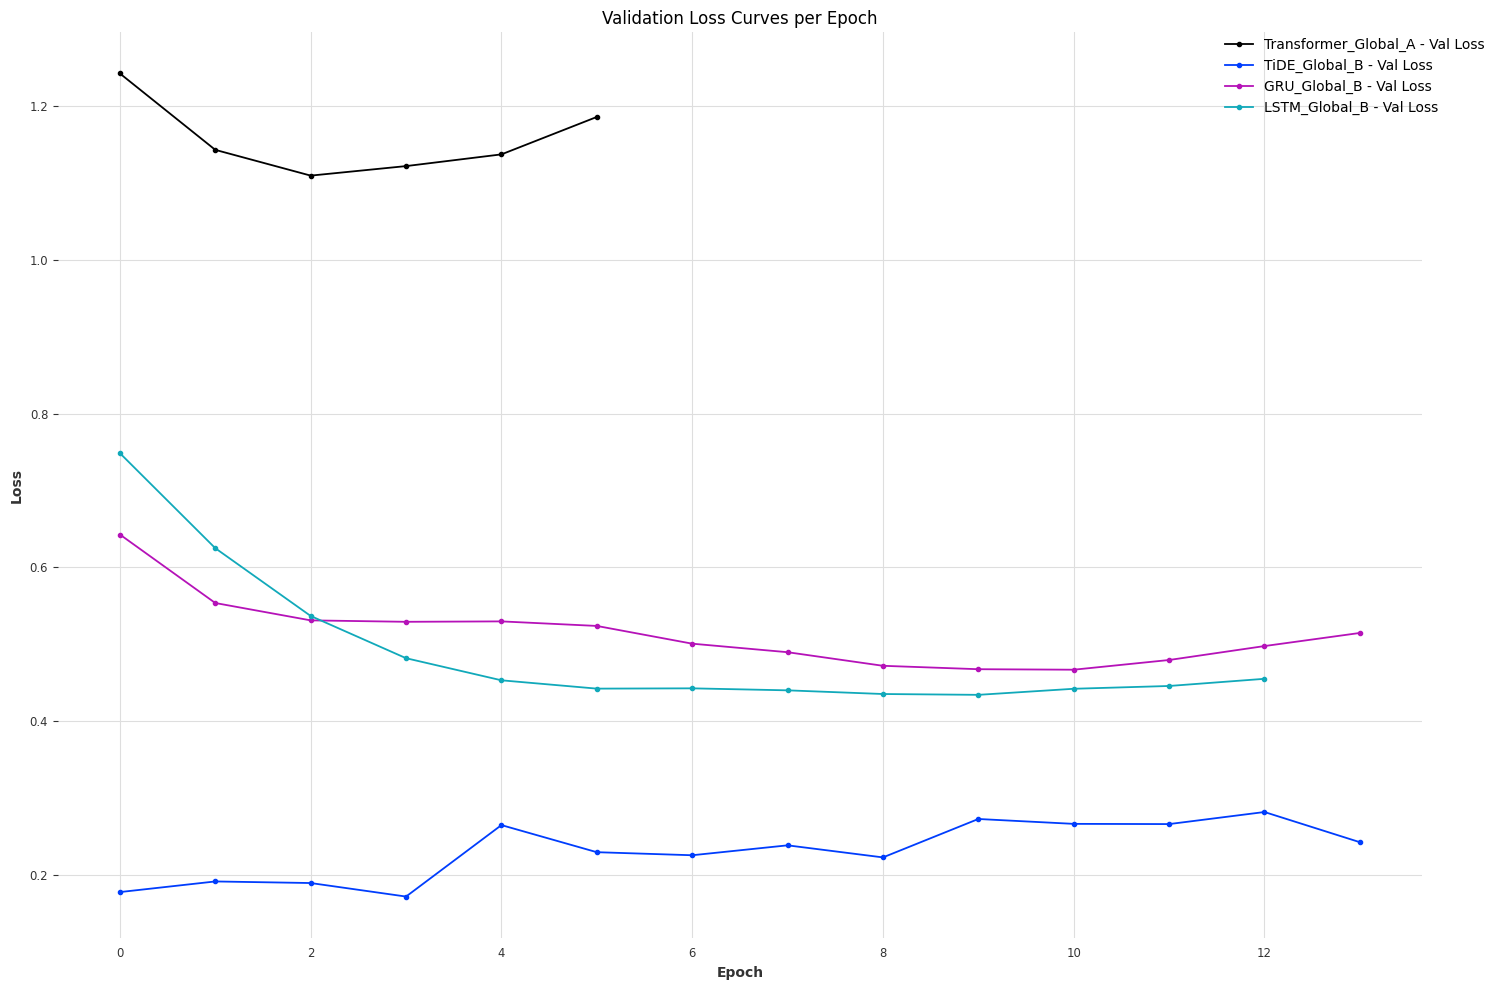

In [ ]:
import os

logs_base_dir = "notebooks\TS\extra\lightning_logs" 

model_names_A = list(fitted_models_A.keys()) if 'fitted_models_A' in locals() and fitted_models_A else []
model_names_B = list(fitted_models_B.keys()) if 'fitted_models_B' in locals() and fitted_models_B else []

model_names_LSTM = list(fitted_models_LSTM.keys()) if 'fitted_models_LSTM' in locals() and fitted_models_LSTM else []
model_names_GRU = list(fitted_models_GRU.keys()) if 'fitted_models_GRU' in locals() and fitted_models_GRU else []
model_names_Transformer = list(fitted_models_transformer.keys()) if 'fitted_models_transformer' in locals() and fitted_models_transformer else []

all_model_names_with_logs = list(set(model_names_A + model_names_B + model_names_LSTM + model_names_GRU + model_names_Transformer))


if not all_model_names_with_logs:
    print("Не найдены имена моделей для построения графиков Loss.")
else:
    plt.figure(figsize=(15, 10))

    for model_name in all_model_names_with_logs:
        model_log_path_base = os.path.join(logs_base_dir, model_name)
    

        versions = [d for d in os.listdir(model_log_path_base) if os.path.isdir(os.path.join(model_log_path_base, d)) and d.startswith('version_')]
        
        latest_version_dir = sorted(versions)[-1]
        metrics_file_path = os.path.join(model_log_path_base, latest_version_dir, "metrics.csv")

        if not os.path.exists(metrics_file_path):
            print(f"Warning: Файл metrics.csv не найден для модели {model_name} по пути: {metrics_file_path}")
            continue
            
        try:
            metrics_df = pd.read_csv(metrics_file_path)
            
            metrics_df = metrics_df.dropna(subset=['epoch', 'step'], how='all') 
            metrics_df = metrics_df.dropna(subset=['val_loss'], how='any')

            if 'epoch' in metrics_df.columns and 'val_loss' in metrics_df.columns:
                plot_df = metrics_df.dropna(subset=['epoch', 'val_loss'])
                if not plot_df.empty:
                    plt.plot(
                        plot_df['epoch'], 
                        plot_df['val_loss'], 
                        label=f'{model_name} - Val Loss', 
                        marker='.', 
                        linestyle='-'
                        )
                    if 'train_loss' in plot_df.columns:
                         if not plot_df['train_loss'].isnull().all():
                            plt.plot(
                                plot_df['epoch'], 
                                plot_df['train_loss'], 
                                label=f'{model_name} - Train Loss (end of epoch)', 
                                marker='.', 
                                linestyle=':'
                                )
                else:
                    print(f"Нет данных для построения графика val_loss для {model_name}.")

            else:
                print(f"Колонки 'epoch' или 'val_loss' не найдены в metrics.csv для {model_name}.")

        except FileNotFoundError:
            print(f"Файл логов не найден для {model_name} по пути: {metrics_file_path}")
        except pd.errors.EmptyDataError:
            print(f"Файл metrics.csv для {model_name} пуст: {metrics_file_path}")
        except Exception as e:
            print(f"Ошибка при чтении или построении графика логов для {model_name}: {e}")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss Curves per Epoch')
    plt.legend(
        loc='best', 
        bbox_to_anchor=(1.05, 1), 
        borderaxespad=0.
        )
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Из графика видно, что лчше относительно других обучилась TiDE 

In [164]:
test_series_before = test_series_scaled[0].slice_n_points_before(n=30, end_ts=pd.Timestamp("2017-04-01 00:00:00"))

test_future_cov_scaled_before = test_future_cov_scaled[0].slice_n_points_before(n=60, end_ts=pd.Timestamp("2017-05-01 00:00:00"))

In [172]:
test_series_after = test_series_scaled[0].slice_n_points_after(n=30, start_ts=pd.Timestamp("2017-04-01 00:00:00"))

test_past_cov_scaled_after = test_past_cov_scaled[0].slice_n_points_after(n=60, start_ts=pd.Timestamp("2017-03-03 00:00:00"))

Делаем прогнозы

In [ ]:
if not test_series_scaled:
    print("Список тестовых рядов (test_series_for_metrics) пуст. Прогнозирование невозможно.")
else:
    forecast_horizon = len(test_series_before[0])
    print(f"Горизонт прогнозирования для каждой серии: {forecast_horizon} шагов.")

    
    forecasts_LSTM_scaled = {}
    forecasts_GRU_scaled = {}
    forecasts_Transformer_scaled = {}

    for name, model in fitted_models_LSTM.items():
        print(f"Прогнозирование с моделью {name}...")
        try:
            forecasts_LSTM_scaled[name] = model.predict(
                30,
                series=test_series_before,
                future_covariates=test_future_cov_scaled_before,
            )
            print(f"Прогноз для {name} получен.")
        except Exception as e:
            print(f"Ошибка при прогнозировании с моделью {name}: {e}")
            forecasts_LSTM_scaled[name] = [None] * len(test_series_scaled)
    
    for name, model in fitted_models_GRU.items():
        print(f"Прогнозирование с моделью {name}...")
        try:
            forecasts_GRU_scaled[name] = model.predict(
                30,
                series=test_series_before,
                future_covariates=test_future_cov_scaled_before,
            )
            print(f"Прогноз для {name} получен.")
        except Exception as e:
            print(f"Ошибка при прогнозировании с моделью {name}: {e}")
            forecasts_GRU_scaled[name] = [None] * len(test_series_scaled)

    for name, model in fitted_models_transformer.items():
        print(f"Прогнозирование с моделью {name}...")
        try:
            forecasts_Transformer_scaled[name] = model.predict(
                30,
                series=test_series_before,
                past_covariates=test_past_cov_scaled_after,
            )
            print(f"Прогноз для {name} получен.")
        except Exception as e:
            print(f"Ошибка при прогнозировании с моделью {name}: {e}")
            forecasts_Transformer_scaled[name] = [None] * len(test_series_scaled)

    forecasts_B_scaled = {}
    for name, model in fitted_models_B.items():
        print(f"Прогнозирование с моделью {name} С ковариатами...")
        try:
            forecasts_B_scaled[name] = model.predict(
                30,
                series=test_series_before,
                past_covariates=test_past_cov_scaled_after,
                future_covariates=test_future_cov_scaled_before,
            )
            print(f"Прогноз для {name} С ковариатами получен.")
        except Exception as e:
            print(f"Ошибка при прогнозировании с моделью {name} С ковариатами: {e}")
            forecasts_B_scaled[name] = [None] * len(test_series_scaled)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Горизонт прогнозирования для каждой серии: 1 шагов.
Прогнозирование с моделью LSTM_Global_B...


Predicting: |          | 0/? [00:00<?, ?it/s]

Прогноз для LSTM_Global_B получен.
Прогнозирование с моделью GRU_Global_B...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


Прогноз для GRU_Global_B получен.
Прогнозирование с моделью Transformer_Global_A...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Прогноз для Transformer_Global_A получен.

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Прогнозирование с моделью TiDE_Global_B С ковариатами...


Predicting: |          | 0/? [00:00<?, ?it/s]

Прогноз для TiDE_Global_B С ковариатами получен.


Оцениваем качество прогнозов

Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=14) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.


Истинные значения для оценки (длина 30) подготовлены.
LSTM_Global_B - MAE: 243.95, RMSE: 276.47, MAPE: 121.14%
GRU_Global_B - MAE: 588.50, RMSE: 646.19, MAPE: 334.41%
Transformer_Global_A - MAE: 201.26, RMSE: 236.45, MAPE: 111.86%
TiDE_Global_B - MAE: 189.34, RMSE: 216.53, MAPE: 104.00%
                             MAE        RMSE        MAPE
LSTM_Global_B         243.950933  276.472245  121.136052
GRU_Global_B          588.497743  646.186410  334.405930
Transformer_Global_A  201.264933  236.450209  111.862018
TiDE_Global_B         189.344362  216.528726  104.004639


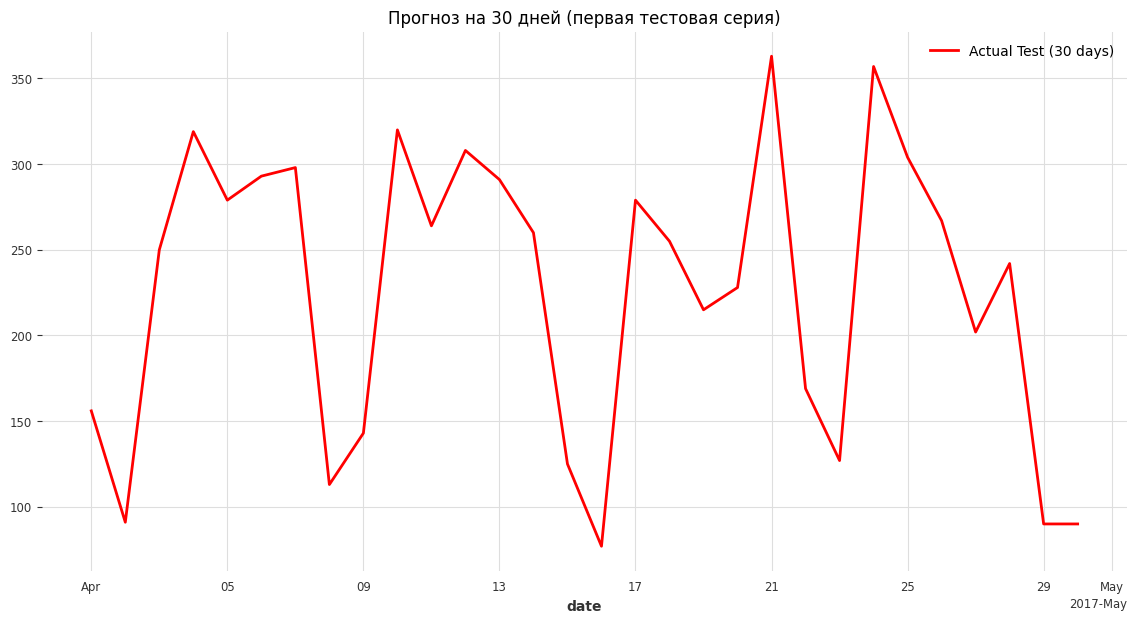

In [ ]:
# Истинные значения для оценки (немасштабированные)
try:
    if test_series_after is not None:
        actual_series_to_evaluate = scaler_target.inverse_transform(test_series_after)
        print(f"Истинные значения для оценки (длина {len(actual_series_to_evaluate)}) подготовлены.")
    else:
        print("Ошибка: test_series_after пуст или None. Оценка невозможна.")
        actual_series_to_evaluate = None
except Exception as e:
    print(f"Ошибка при обратном масштабировании test_series_after: {e}")
    actual_series_to_evaluate = None


# Прогнозы (немасштабированные)
forecasts_LSTM_eval = {}
for name, forecast_scaled in forecasts_LSTM_scaled.items():
    if forecast_scaled is not None:
        try:
            forecasts_LSTM_eval[name] = scaler_target.inverse_transform(forecast_scaled)
        except Exception as e:
            print(f"Ошибка при обратном масштабировании прогноза {name}: {e}")
            forecasts_LSTM_eval[name] = None
    else:
        forecasts_LSTM_eval[name] = None


forecasts_GRU_eval = {}
for name, forecast_scaled in forecasts_GRU_scaled.items():
    if forecast_scaled is not None:
        try:
            forecasts_GRU_eval[name] = scaler_target.inverse_transform(forecast_scaled)
        except Exception as e:
            print(f"Ошибка при обратном масштабировании прогноза {name}: {e}")
            forecasts_GRU_eval[name] = None
    else:
        forecasts_GRU_eval[name] = None

forecasts_Transformer_eval = {}
for name, forecast_scaled in forecasts_Transformer_scaled.items():
    if forecast_scaled is not None:
        try:
            forecasts_Transformer_eval[name] = scaler_target.inverse_transform(forecast_scaled)
        except Exception as e:
            print(f"Ошибка при обратном масштабировании прогноза {name}: {e}")
            forecasts_Transformer_eval[name] = None
    else:
        forecasts_Transformer_eval[name] = None
        
forecasts_B_eval = {}
for name, forecast_scaled in forecasts_B_scaled.items():
    if forecast_scaled is not None:
        try:
            forecasts_B_eval[name] = scaler_target.inverse_transform(forecast_scaled)
        except Exception as e:
            print(f"Ошибка при обратном масштабировании прогноза {name}: {e}")
            forecasts_B_eval[name] = None
    else:
        forecasts_B_eval[name] = None

# Объединяем все прогнозы в один словарь для удобства оценки
all_forecasts_eval = {
    **forecasts_LSTM_eval,
    **forecasts_GRU_eval,
    **forecasts_Transformer_eval,
    **forecasts_B_eval
}

results_first_series = {}

if actual_series_to_evaluate is None:
    print("Истинные значения для оценки отсутствуют. Расчет метрик невозможен.")
else:
    for model_name, forecast_series in all_forecasts_eval.items():
        if forecast_series is None:
            print(f"Прогноз для модели {model_name} отсутствует или пуст. Пропускаем оценку.")
            results_first_series[model_name] = {"MAE": float('nan'), "RMSE": float('nan'), "MAPE": float('nan')}
            continue
        
        try:
            current_mae = mae(actual_series_to_evaluate, forecast_series)
            current_rmse = rmse(actual_series_to_evaluate, forecast_series)
            current_mape = mape(actual_series_to_evaluate, forecast_series)
            
            results_first_series[model_name] = {
                "MAE": current_mae,
                "RMSE": current_rmse,
                "MAPE": current_mape
            }
            print(f"{model_name} - MAE: {current_mae:.2f}, RMSE: {current_rmse:.2f}, MAPE: {current_mape:.2f}%")
            
        except Exception as e:
            print(f"Ошибка при расчете метрики для модели {model_name}: {e}")
            results_first_series[model_name] = {"MAE": float('nan'), "RMSE": float('nan'), "MAPE": float('nan')}

if results_first_series:
    results_df_first_series = pd.DataFrame.from_dict(results_first_series, orient='index')
    print(results_df_first_series)
else:
    print("Словарь результатов для первой серии пуст.")

if actual_series_to_evaluate:
    plt.figure(figsize=(14, 7))
    
    actual_series_to_evaluate.plot(label='Actual Test (30 days)', color='red')

    for model_name, forecast_series in all_forecasts_eval.items():
        if forecast_series is not None and not forecast_series:
            forecast_to_plot = forecast_series
            forecast_to_plot.plot(label=f'{model_name} Forecast (30 days)', linestyle='--')
    
    plt.title('Прогноз на 30 дней (первая тестовая серия)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Не могу построить график: actual_series_to_evaluate отсутствует.")

Модели продемонстрировали низкое качество. Попробуем добавить/изменить архитектуру, подобрать гиперпараметры